In [218]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import SimpleRNN
from sklearn.metrics import classification_report
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.layers import LSTM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import locale

In [219]:
data = pd.read_csv("Danube ammonium level Time Series (1).csv",sep=";")

data = data[['Ammonium']]
data = np.array(data)

locale.setlocale(locale.LC_ALL, 'nl_NL')
for i in range(0,len(data)):
    rep = data[i]
    rep1 = locale.atof(rep[0])
    data[i] = rep1

max = data.max()
min = data.min()

train1 = (data[0:251,0] - min)/(max - min)
test1 = (data[252:263,0] - min)/(max - min)

train = np.zeros((251,2))
test = np.zeros((11,2))

for i in range(0,251) :
    train[i,0] = train1[i]
    train[i,1] = (data[i+1,0] - min)/(max - min)

for i in range(0,11) :
    test[i,0] = test1[i]
    test[i,1] = (data[252+i+1,0] - min)/(max - min)
    
X_train = train[:,0]
Y_train = train[:,1]

X_test = test[:,0]
Y_test = test[:,1]

#On remodèle l'ensemble des données d'entrée
X_train = np.reshape(X_train, (X_train.shape[0],1,1))
X_test = np.reshape(X_test, (X_test.shape[0],1,1))
Y_test_plot = Y_test*(max-min) + min

In [220]:
#création et entraînement du réseau LSTM
model = Sequential()
model.add(LSTM(10, input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [221]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=10,validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50
26/26 [==============================] - 6s 51ms/step - loss: 0.0802 - mse: 0.0802 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 2/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0580 - mse: 0.0580 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 3/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 4/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 5/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 6/50
26/26 [==============================] - 0s 8ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 7/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 8/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0290 - mse: 0.0

In [222]:
pred_LSTM = model.predict(X_test)*(max-min) + min

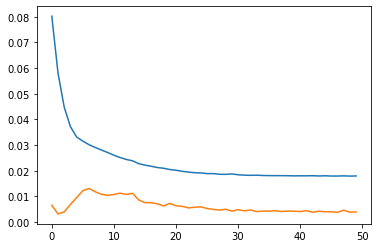

In [223]:
#plot
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
score = model.evaluate(X_test, Y_test, verbose=0)
RMSE_LSTM = np.sqrt(score[1])

In [224]:
#création et entraînement du réseau RNN

model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(1,1), return_sequences=True))
model.add(SimpleRNN(units=1))
model.summary()


# compile the model
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['mse'])

# now we just update our model fit call
history = model.fit(X_train, Y_train,
                    epochs=50, # you can set this to a big number!
                    batch_size=10,
                    validation_data = (X_test, Y_test),
                    verbose=1)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 1, 50)             2600      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 1)                 52        
                                                                 
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
26/26 [==============================] - 4s 33ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 2/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 4/50
26/26 [==============================] - 0s 6

Test loss     : 0.00406739441677928
Test mse : 0.00406739441677928


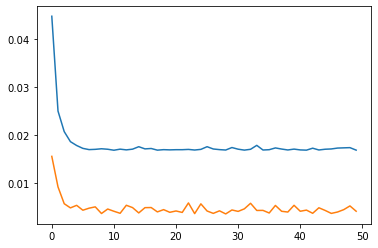

In [225]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test loss     :', score[0])
print('Test mse :', score[1])

RMSE_RNN = np.sqrt(score[1])
pred_RNN = model.predict(X_test)*(max-min) + min

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

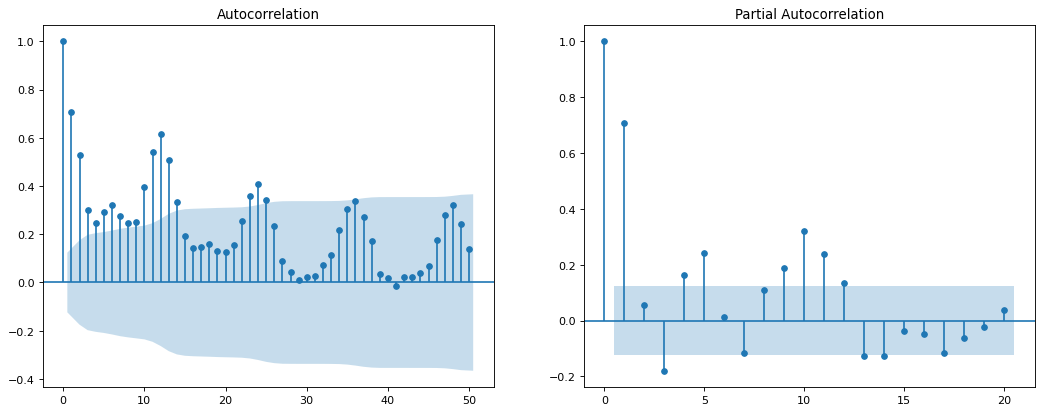

In [226]:
X_train_l = []
for k in range(len(X_train)):
    X_train_l.append(X_train[k,0,0])

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(X_train_l, ax=ax1, lags=50)
plot_pacf(X_train_l, ax=ax2, lags=20)
plt.show()

In [227]:
from statsmodels.tsa.arima_model import ARIMA

start=len(X_train)
end=len(X_train)+len(X_test)-1
min_rmse_arima = [10,0,0]
for i in range(0,6) :
    for j in range(0,6) :
        if (i+j<9): #Si l'on prend (i,j) tel que i+j >= 9, le programme affiche une erreur
            model=ARIMA(X_train,order=(i,0,j))
            model=model.fit()
            pred=model.predict(start=start,end=end,typ='levels')
            rmse = np.mean((pred - Y_test)**2)**.5
            if (rmse < min_rmse_arima[0]) :
                min_rmse_arima = [rmse, i, j]
            print("RMSE(ar = %.3f, ma = %.3f) = %.3f" % (i,j,rmse))
            print("RMSE minimal pour arima(ar = %.3f, ma = %.3f) = %.3f" % (min_rmse_arima[1],min_rmse_arima[2],min_rmse_arima[0]))

C:\Users\octav\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RMSE(ar = 0.000, ma = 0.000) = 0.120
RMSE minimal pour arima(ar = 0.000, ma = 0.000) = 0.120
RMSE(ar = 0.000, ma = 1.000) = 0.121
RMSE minimal pour arima(ar = 0.000, ma = 0.000) = 0.120
RMSE(ar = 0.000, ma = 2.000) = 0.123
RMSE minimal pour arima(ar = 0.000, ma = 0.000) = 0.120
RMSE(ar = 0.000, ma = 3.000) = 0.123
RMSE minimal pour arima(ar = 0.000, ma = 0.000) = 0.120
RMSE(ar = 0.000, ma = 4.000) = 0.124
RMSE minimal pour arima(ar = 0.000, ma = 0.000) = 0.120
RMSE(ar = 0.000, ma = 5.000) = 0.124
RMSE minimal pour arima(ar = 0.000, ma = 0.000) = 0.120
RMSE(ar = 1.000, ma = 0.000) = 0.114
RMSE minimal pour arima(ar = 1.000, ma = 0.000) = 0.114
RMSE(ar = 1.000, ma = 1.000) = 0.111
RMSE minimal pour arima(ar = 1.000, ma = 1.000) = 0.111
RMSE(ar = 1.000, ma = 2.000) = 0.122
RMSE minimal pour arima(ar = 1.000, ma = 1.000) = 0.111
RMSE(ar = 1.000, ma = 3.000) = 0.055
RMSE minimal pour arima(ar = 1.000, ma = 3.000) = 0.055
RMSE(ar = 1.000, ma = 4.000) = 0.054
RMSE minimal pour arima(ar = 1.00

C:\Users\octav\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE(ar = 3.000, ma = 4.000) = 0.112
RMSE minimal pour arima(ar = 1.000, ma = 5.000) = 0.054
RMSE(ar = 3.000, ma = 5.000) = 0.136
RMSE minimal pour arima(ar = 1.000, ma = 5.000) = 0.054
RMSE(ar = 4.000, ma = 0.000) = 0.108
RMSE minimal pour arima(ar = 1.000, ma = 5.000) = 0.054
RMSE(ar = 4.000, ma = 1.000) = 0.053
RMSE minimal pour arima(ar = 4.000, ma = 1.000) = 0.053
RMSE(ar = 4.000, ma = 2.000) = 0.099
RMSE minimal pour arima(ar = 4.000, ma = 1.000) = 0.053
RMSE(ar = 4.000, ma = 3.000) = 0.098
RMSE minimal pour arima(ar = 4.000, ma = 1.000) = 0.053
RMSE(ar = 4.000, ma = 4.000) = 0.051
RMSE minimal pour arima(ar = 4.000, ma = 4.000) = 0.051
RMSE(ar = 5.000, ma = 0.000) = 0.082
RMSE minimal pour arima(ar = 4.000, ma = 4.000) = 0.051
RMSE(ar = 5.000, ma = 1.000) = 0.054
RMSE minimal pour arima(ar = 4.000, ma = 4.000) = 0.051
RMSE(ar = 5.000, ma = 2.000) = 0.098
RMSE minimal pour arima(ar = 4.000, ma = 4.000) = 0.051
RMSE(ar = 5.000, ma = 3.000) = 0.098
RMSE minimal pour arima(ar = 4.00

In [228]:
model=ARIMA(X_train,order=(4,0,4))
model=model.fit()
pred_ARIMA=model.predict(start=start,end=end,typ='levels')
RMSE_ARIMA = np.mean((pred_ARIMA - Y_test)**2)**.5
pred_ARIMA=pred_ARIMA*(max-min) + min

In [229]:
import statsmodels.api as sm
start = len(X_train_l)
end = len(X_train)+len(X_test)-1
mod = sm.tsa.statespace.SARIMAX(X_train_l, order = (4,0,4), seasonal_order = (0,0,0,12), enforce_stationarity=False, enforce_invertibility = False)
result = mod.fit()
pred_SARIMA= result.predict(start=start, end=end, typ='levels')
MSE = (np.mean((pred_SARIMA-Y_test)**2))
print(MSE)
RMSE_SARIMA = np.sqrt(MSE)
pred_SARIMA = pred_SARIMA*(max-min) + min

0.002892338775763097


C:\Users\octav\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


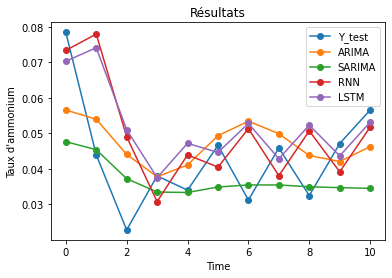

In [242]:
# On représentes toutes nos prédictions :
plt.plot(Y_test_plot, "-o", label="Y_test")
plt.plot(pred_ARIMA, "-o", label="ARIMA")
plt.plot(pred_SARIMA, "-o", label="SARIMA")
plt.plot(pred_RNN, "-o", label="RNN")
plt.plot(pred_LSTM, "-o", label="LSTM")
plt.legend()
plt.ylabel("Taux d'ammonium")
plt.xlabel('Time')
plt.title('Résultats')
plt.show()

In [231]:
print("RMSE RNN :", RMSE_RNN)
print("RMSE LSTM :", RMSE_LSTM)
print("RMSE ARIMA :", RMSE_ARIMA)
print("RMSE SARIMA :", RMSE_SARIMA)

RMSE RNN : 0.06377612732660458
RMSE LSTM : 0.06271038557546109
RMSE ARIMA : 0.05067685942411851
RMSE SARIMA : 0.05378046834830557


In [235]:
data = pd.read_csv("Danube ammonium level complete data Time Series.csv",sep=";")

data = data[['Ammonium', 'TSS', 'Alkalinity', 'Conductivity', 'DO', 'pH', 'WT']]
data = np.array(data)

locale.setlocale(locale.LC_ALL, 'nl_NL')

shape = data.shape
for j in range(0, shape[1]) :
    for i in range(0,shape[0]):
        rep = data[i,j]
        rep1 = locale.atof(rep)
        data[i,j] = rep1
print(data)
max = data.max(axis=0)
min = data.min(axis=0)

train1 = (data[0:251,:] - min)/(max - min)
test1 = (data[252:263,:] - min)/(max - min)

train = np.zeros((251, shape[1] + 1))
test = np.zeros((11, shape[1] + 1))

for i in range(0, 251) :
    for j in range(0, shape[1]) :
        train[i,j] = train1[i,j]
    train[i,shape[1]] = (data[i+1,0] - min[0])/(max[0] - min[0])

for i in range(0,11) :
    for j in range(0, shape[1]) :
        test[i,j] = test1[i,j]
    test[i,shape[1]] = (data[252+i+1,0] - min[0])/(max[0] - min[0])

X_train = train[:,:shape[1]]
Y_train = train[:,shape[1]]

X_test = test[:,:shape[1]]
Y_test = test[:,shape[1]]





[[0.253333 7.016667 3.836667 ... 12.383333 8.056667 2.075]
 [0.218889 6.666667 3.968889 ... 12.877778 8.068889 1.911111]
 [0.242 21.42 3.798 ... 12.99 8.083 3.93]
 ...
 [0.032474 17.1 3.156364 ... 10.381818 8.221818 12.172727]
 [0.047125 20.785714 3.135455 ... 11.690909 8.211818 6.790909]
 [0.056563 13.4 3.178182 ... 12.981818 8.218182 3.8]]


In [289]:
from keras.layers import SimpleRNN
tf.random.set_seed(1234)

model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(SimpleRNN(units=1))
model.summary()


# compile the model
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['mse'])

# now we just update our model fit call
history = model.fit(X_train, Y_train,
                    epochs=40, # you can set this to a big number!
                    batch_size=10,
                    validation_data = (X_test, Y_test),
                    verbose=1)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_52 (SimpleRNN)   (None, 7, 10)             120       
                                                                 
 simple_rnn_53 (SimpleRNN)   (None, 1)                 12        
                                                                 
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
26/26 [==============================] - 2s 14ms/step - loss: 0.0411 - mse: 0.0411 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 2/40
26/26 [==============================] - 0s 4ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 3/40
26/26 [==============================] - 0s 4ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 4/40
26/26 [==============================] - 0s 4ms/s

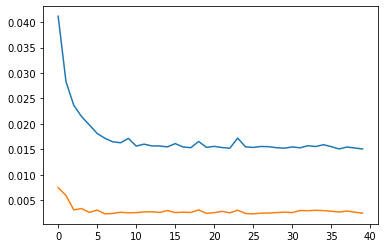

In [290]:
#plot
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

Test loss     : 0.00249275891110301
Test mse : 0.00249275891110301


Text(0.5, 1.0, 'Résultats')

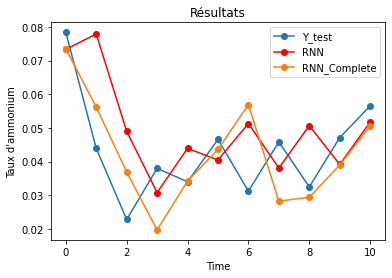

In [291]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test loss     :', score[0])
print('Test mse :', score[1])

RMSE_RNN_C = np.sqrt(score[1])
pred_RNN_C = model.predict(X_test)*(max[0]-min[0]) + min[0]


plt.plot(Y_test_plot, "-o", label="Y_test")
plt.plot(pred_RNN, "-o", label="RNN", color='r')
plt.plot(pred_RNN_C, "-o", label="RNN_Complete")
plt.legend()
plt.ylabel("Taux d'ammonium")
plt.xlabel('Time')
plt.title('Résultats')

In [293]:
print(RMSE_RNN_C)

0.04992753660158901
